In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import poisson, pearsonr
from statsmodels.stats.multitest import multipletests
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Paths to data directories

In [19]:
predictions_dir = "../basenji2/test"
plot_dir = "../plots"

### Read in metadata about sequences and targets

In [38]:
sequences = pd.read_csv(f"{predictions_dir}/reference_sequence_data/test_sequences_annotated.bed",  sep="\t")

targets_with_assay_type = pd.read_excel(f"{predictions_dir}/reference_sequence_data/basenji_targets_with_assay_type.xlsx", 
                                        sheet_name="Supplementary Table 2")
targets_with_assay_type.loc[targets_with_assay_type["assay_subtype"].isin(["DNase", "ATAC"]), 
                            "assay_subtype"] = "DNase/ATAC"

### Read in predictions and experimental targets

In [39]:
num_models = 5

# read in predictions
preds = np.empty((len(sequences), len(targets_with_assay_type), num_models), dtype=np.float16)

for i, model in enumerate(range(1, num_models+1)):
    print(model)
       
    preds[:, :, i] = h5py.File(f"{predictions_dir}/rep_{model}/preds.h5", "r")["preds"][:,:,:].reshape(-1, 5313)

1
2
3
4
5


In [5]:
# read in experimental targets (same for all replicates)
targets = h5py.File(f"{predictions_dir}/rep_1/targets.h5", "r")["targets"][:,:,:].reshape(-1, 5313)

In [6]:
def call_peaks(preds_arr, fdr=0.05):
    # adapted from https://github.com/calico/basenji/blob/615b9eec8a591783b16d959029ddad08edae853d/bin/basenji_test.py#L383
    test_targets_ti_lambda = np.mean(np.round(preds_arr, decimals=1)*10)
    test_targets_pvals = 1 - poisson.cdf(
      np.round(np.round(preds_arr, decimals=1)*10) - 1, mu=test_targets_ti_lambda)
    test_targets_peaks, test_targets_qvals, _, _ = multipletests(test_targets_pvals, 
                                                                 alpha=fdr, method="fdr_bh", 
                                                                 is_sorted=False, returnsorted=False)
    return test_targets_peaks.astype(bool), test_targets_qvals

In [ ]:
# call peaks for downsampled dataset
sample_inds = np.arange(1, preds.shape[0], 10)
for i, model in enumerate(range(1, num_models+1)):
    print(model)  
    preds_model = preds[sample_inds,:,i]
    
    preds_peaks = h5py.File(f"{predictions_dir}/rep_{model}/preds_downsampled_called_peaks_fdr_01.h5", 'w')
    preds_peaks_arr = np.empty(preds_model.shape, dtype=np.float16)
    for idx in tqdm(range(preds_model.shape[1])):
        peaks, qvals = call_peaks(preds_model[:,idx], fdr=0.01) 
        preds_peaks_arr[:, idx] = qvals       
    preds_peaks.create_dataset(f"qvals", data=preds_peaks_arr)
    preds_peaks.close()

print("targets")
targets_subs = targets[sample_inds,:]

targets_peaks = h5py.File(f"{predictions_dir}/rep_1/targets_downsampled_called_peaks_fdr_01.h5", 'w')
targets_peaks_arr = np.empty(targets_subs.shape, dtype=np.float16)
for idx in tqdm(range(targets_subs.shape[1])):
    peaks, qvals = call_peaks(targets_subs[:,idx], fdr=0.01) 
    targets_peaks_arr[:, idx] = qvals
targets_peaks.create_dataset(f"qvals", data=targets_peaks_arr)
targets_peaks.close()

In [8]:
# read in peak called predictions and targets
binarized_preds = []
for i, model in enumerate(range(1, num_models+1)):
    print(model)
       
    binarized_preds.append(h5py.File(
        f"{predictions_dir}/rep_{model}/preds_downsampled_called_peaks_fdr_01.h5", 
                               "r")["qvals"][:,:])
binarized_preds = np.stack(binarized_preds, axis=2)
binarized_targets = h5py.File(
    f"{predictions_dir}/rep_1/targets_downsampled_called_peaks_fdr_01.h5", "r")["qvals"][:,:]

binarized_preds = binarized_preds < 0.01
binarized_targets = binarized_targets < 0.01

1
2
3
4
5


# Figures

### Fig S1

In [42]:
# read in test set performance for model replicates
models = ["cross2020", "rep_1", "rep_2", "rep_3", "rep_4", "rep_5"]
acc = {}
for model in models:
    acc[model] = pd.read_csv(f"{predictions_dir}/{model}/acc.txt", sep="\t", index_col=0)
    acc[model]["Assay Type"] = targets_with_assay_type["assay_subtype"].values

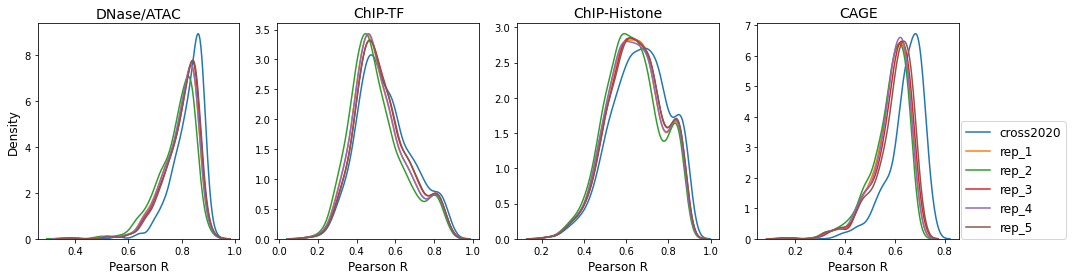

In [43]:
fig, ax = plt.subplots(1, 4, figsize=(15,4))

for i, assay in enumerate(acc[model]["Assay Type"].unique()):
    for model in ["cross2020", "rep_1", "rep_2", "rep_3", "rep_4", "rep_5"]:
        sns.kdeplot(acc[model][acc[model]["Assay Type"] == assay]["pearsonr"], label=model, ax=ax[i])
        
    ax[i].set_title(assay, fontsize=14)
    ax[i].set_xlabel("Pearson R", fontsize=12)
    if i == 0:
        ax[i].set_ylabel("Density", fontsize=12)
    else:
        ax[i].set_ylabel("")
        
ax[i].legend(loc=(1.01,0), fontsize=12)
plt.tight_layout()
plt.savefig(f"{plot_dir}/test_set_accuracy_comparison_by_assay_kde.pdf",
            dpi=300)

### Fig 1A

In [40]:
corrs = []
for track in tqdm(range(preds.shape[1])):
    corrs.append(pearsonr(np.log2(preds[:, track, 0]+1), 
                          np.log2(preds[:, track, 1]+1))[0])
corrs = np.array(corrs)
targets_with_assay_type["Pearson R between model 1 and 2 predictions"] = corrs

100%|██████████| 5313/5313 [40:51<00:00,  2.17it/s]


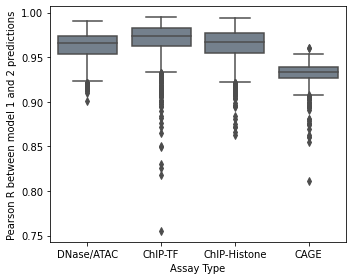

In [41]:
x="assay_subtype"
y="Pearson R between model 1 and 2 predictions"

fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.boxplot(data=targets_with_assay_type, 
            x=x, y=y, color="slategray")
plt.xlabel("Assay Type")
plt.tight_layout()

plt.savefig(f"{plot_dir}/pearsonr_between_models_by_assay.pdf", dpi=300)

### Fig 1C

In [16]:
# subset data to downsampled sequences
sample_inds = np.arange(1, preds.shape[0], 10)
preds = preds[sample_inds,:,:]
targets = targets[sample_inds,:]
sequences = sequences.loc[sample_inds]
sequences.index = np.arange(len(sequences))

Prediction consistency at all bins

In [ ]:
# for each track, compute the proportion of sequences predicted consistently correct, consistently incorrect, and inconsistent
ensemble_agreement = pd.DataFrame([])

for idx in tqdm(np.arange(binarized_preds.shape[1])):
    track_name = targets_with_assay_type.loc[idx, "description"]
    assay_subtype = targets_with_assay_type.loc[idx, "assay_subtype"]
    binarized_preds_idx = binarized_preds[:,idx,:]
    binarized_targets_idx = binarized_targets[:, idx]

    # compare agreement on all sequences
    all_models_agree_inds = np.where((np.abs(binarized_preds_idx.sum(axis=1) - 2.5) + 2.5) == 5)[0]
    all_models_correct_inds = num_correct_inds = np.where(np.equal(binarized_preds_idx.T, 
                                                                   binarized_targets_idx).T.sum(axis=1) == 5)[0]

    bin_inds_dict = {
        "Consistently correct": len(np.intersect1d(all_models_agree_inds,all_models_correct_inds)),
        "Consistently incorrect": len(np.setdiff1d(all_models_agree_inds,all_models_correct_inds)),
        "Inconsistent": len(binarized_targets_idx) - len(all_models_agree_inds)
    }
    
    for bin_name, num_bin in bin_inds_dict.items():
        ensemble_agreement = ensemble_agreement.append({
            "Track": track_name,
            "Assay Type": assay_subtype,
            "Bin": bin_name,
            "Number of sequences in bin": num_bin,
            "Proportion of sequences": num_bin/len(binarized_targets_idx)
        }, ignore_index=True)

 17%|█▋        | 896/5313 [00:59<04:29, 16.37it/s]

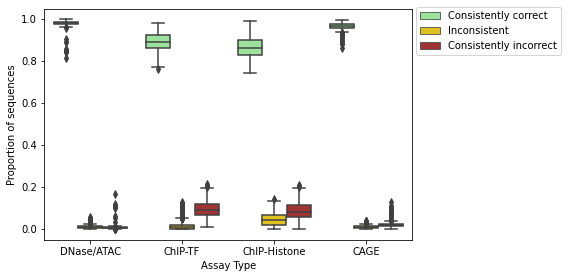

In [29]:
x="Assay Type"
y="Proportion of sequences"
hue="Bin"
order=["DNase/ATAC", "ChIP-TF", "ChIP-Histone", "CAGE"]
hue_order=["Consistently correct", "Inconsistent", "Consistently incorrect"]
colors = ['lightgreen', 'gold', 'firebrick']

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(data=ensemble_agreement,
            x=x, y=y, hue=hue, palette=colors,
            order=order, hue_order=hue_order)
plt.legend(loc=(1.01,0.8))
plt.tight_layout()                  
plt.savefig(f"{plot_dir}/reference_sequence_consistency_correctness_by_assay_all_sequences.pdf", dpi=300)

Prediction consistency at peaks

In [17]:
# for each track, compute the proportion of peak sequences predicted consistently correct, consistently incorrect, and inconsistent
ensemble_agreement = pd.DataFrame([])

for idx in tqdm(np.arange(binarized_preds.shape[1])):
    track_name = targets_with_assay_type.loc[idx, "description"]
    assay_subtype = targets_with_assay_type.loc[idx, "assay_subtype"]
    binarized_preds_idx = binarized_preds[:,idx,:]
    binarized_targets_idx = binarized_targets[:, idx]

    # compare agreement on true peaks
    peak_inds = np.where(binarized_targets_idx == 1)[0]
    if len(peak_inds) > 1_00:
        binarized_preds_idx = binarized_preds_idx[peak_inds,:]
        binarized_targets_idx = binarized_targets_idx[peak_inds]
        all_models_agree_inds = np.where((np.abs(binarized_preds_idx.sum(axis=1) - 2.5) + 2.5) == 5)[0]
        all_models_correct_inds = num_correct_inds = np.where(np.equal(binarized_preds_idx.T, 
                                                                       binarized_targets_idx).T.sum(axis=1) == 5)[0]

        bin_inds_dict = {
            "Consistently correct": len(np.intersect1d(all_models_agree_inds,all_models_correct_inds)),
            "Consistently incorrect": len(np.setdiff1d(all_models_agree_inds,all_models_correct_inds)),
            "Inconsistent": len(peak_inds) - len(all_models_agree_inds)
        }
        
        for bin_name, num_bin in bin_inds_dict.items():
            ensemble_agreement = ensemble_agreement.append({
                "Track": track_name,
                "Assay Type": assay_subtype,
                "Bin": bin_name,
                "Number of sequences in bin": num_bin,
                "Proportion of peak sequences": num_bin/len(peak_inds)
            }, ignore_index=True)

100%|██████████| 5313/5313 [00:58<00:00, 91.50it/s] 


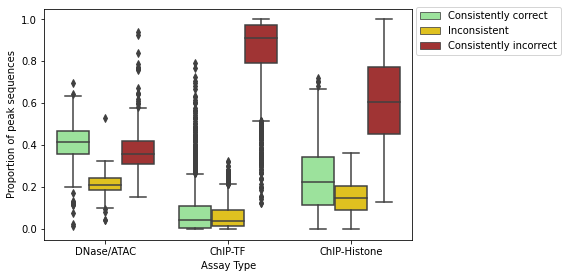

In [20]:
x="Assay Type"
y="Proportion of peak sequences"
hue="Bin"
order=["DNase/ATAC", "ChIP-TF", "ChIP-Histone"]
hue_order=["Consistently correct", "Inconsistent", "Consistently incorrect"]
colors = ['lightgreen', 'gold', 'firebrick']

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(data=ensemble_agreement,
            x=x, y=y, hue=hue, palette=colors,
            order=order, hue_order=hue_order)

plt.legend(loc=(1.01,0.8))
plt.tight_layout()     
plt.savefig(f"{plot_dir}/reference_sequence_consistency_correctness_by_assay_no_cage.pdf", dpi=300)

Prediction consistency at TSSs

In [ ]:
tss_inds = sequences[sequences["TSS distance"] == 0].index.values

ensemble_agreement = pd.DataFrame([])

for idx in tqdm(np.arange(binarized_preds.shape[1])):
    track_name = targets_with_assay_type.loc[idx, "description"]
    assay_subtype = targets_with_assay_type.loc[idx, "assay_subtype"]
    binarized_preds_idx = binarized_preds[:,idx,:]
    binarized_targets_idx = binarized_targets[:, idx]

    # compare agreement at TSS peaks
    peak_inds = np.where(binarized_targets_idx == 1)[0]
    peak_inds = np.intersect1d(peak_inds, tss_inds)
    if len(peak_inds) > 1_00:
        binarized_preds_idx = binarized_preds_idx[peak_inds,:]
        binarized_targets_idx = binarized_targets_idx[peak_inds]

        all_models_agree_inds = np.where((np.abs(binarized_preds_idx.sum(axis=1) - 2.5) + 2.5) == 5)[0]

        all_models_correct_inds = num_correct_inds = np.where(np.equal(binarized_preds_idx.T, 
                                                                       binarized_targets_idx).T.sum(axis=1) == 5)[0]

        bin_inds_dict = {
            "Consistently correct": len(np.intersect1d(all_models_agree_inds,all_models_correct_inds)),
            "Consistently incorrect": len(np.setdiff1d(all_models_agree_inds,all_models_correct_inds)),
            "Inconsistent": len(peak_inds) - len(all_models_agree_inds)
        }

        for bin_name, num_bin in bin_inds_dict.items():
            ensemble_agreement = ensemble_agreement.append({
                "Track": track_name,
                "Assay Type": assay_subtype,
                "Bin": bin_name,
                "Number of sequences in bin": num_bin,
                "Proportion of peak sequences (at TSS)": num_bin/len(peak_inds)
            }, ignore_index=True)

 13%|█▎        | 715/5313 [00:05<00:33, 135.74it/s]

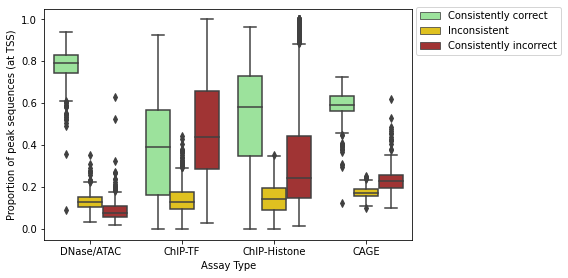

In [33]:
x="Assay Type"
y="Proportion of peak sequences (at TSS)"
hue="Bin"
order=["DNase/ATAC", "ChIP-TF", "ChIP-Histone", "CAGE"]
hue_order=["Consistently correct", "Inconsistent", "Consistently incorrect"]
colors = ['lightgreen', 'gold', 'firebrick']

fig, ax = plt.subplots(figsize=(8, 4))
ax = sns.boxplot(data=ensemble_agreement,
            x=x, y=y, hue=hue, palette=colors,
            order=order, hue_order=hue_order)

plt.legend(loc=(1.01,0.8))
plt.tight_layout()                  
plt.savefig(f"{plot_dir}/reference_sequence_consistency_correctness_by_assay_peaks_at_tss.pdf", dpi=300)

### Fig S2

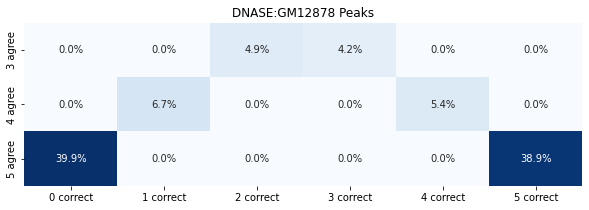

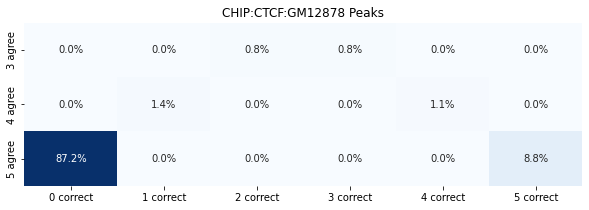

In [34]:
# For GM12878 DNase-seq and CTCF ChIP-seq tracks, look at attributes of sequences in each bin
idxs = [12, 687]
for i, idx in enumerate(idxs):
    track_name = targets_with_assay_type.loc[idx, "description"]
    binarized_preds_idx = binarized_preds[:,idx,:]
    binarized_targets_idx = binarized_targets[:, idx]

    # compare agreement on true peaks
    peak_inds = np.where(binarized_targets_idx == 1)[0]
    binarized_preds_idx_peaks = binarized_preds_idx[peak_inds,:]
    binarized_targets_idx_peaks = binarized_targets_idx[peak_inds]
    
    # calculate number of sequences in each agreement/correctness bin 
    compare_agreement_correctness = pd.DataFrame([])
    for num_agree in range(3, 6):
        num_agree_inds = np.where((np.abs(binarized_preds_idx_peaks.sum(axis=1) - 2.5) + 2.5) == num_agree)[0]

        for num_correct in range(0, 6):
            num_correct_inds = np.where(np.equal(binarized_preds_idx_peaks.T, 
                                                 binarized_targets_idx_peaks).T.sum(axis=1) == num_correct)[0]
            compare_agreement_correctness.loc[f"{num_agree} agree", 
                                              f"{num_correct} correct"] = len(np.intersect1d(num_agree_inds,
                                                                                             num_correct_inds))
    # plot % of sequences in each bin 
    fig, ax = plt.subplots(figsize=(10, 3))
    sns.heatmap(compare_agreement_correctness/len(peak_inds), 
                annot=True, cmap="Blues", ax=ax, fmt=".1%", cbar=False)
    plt.title(f'{track_name} Peaks')
    plt.savefig(f"{plot_dir}/track_{idx}_heatmap.pdf", dpi=300)
              
    # add bin annotations to sequences dataframe 
    all_models_agree_inds = np.where((np.abs(binarized_preds_idx.sum(axis=1) - 2.5) + 2.5) == 5)[0]
    all_models_agree_inds = np.intersect1d(peak_inds, all_models_agree_inds)

    all_models_correct_inds = np.where(np.equal(binarized_preds_idx.T, binarized_targets_idx).T.sum(axis=1) == 5)[0]
    all_models_correct_inds = np.intersect1d(peak_inds, all_models_correct_inds)

    sequences[track_name] = np.nan
    sequences.loc[peak_inds, track_name] = "Inconsistent"
    sequences.loc[np.intersect1d(all_models_agree_inds,all_models_correct_inds),
                  track_name] = "Consistently correct"
    sequences.loc[np.setdiff1d(all_models_agree_inds,all_models_correct_inds),
                  track_name] = "Consistently incorrect"
    sequences[f"{track_name} target"] = targets[:,i]
    sequences[f"{track_name} mean prediction"] = preds[:,i,:].mean(axis=1)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Consistently correct vs. Inconsistent: Mann-Whitney-Wilcoxon test two-sided, P_val:2.620e-14 U_stat=8.665e+04
Inconsistent vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:1.377e-14 U_stat=9.456e+04
Consistently correct vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:2.976e-63 U_stat=1.156e+05
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Consistently correct vs. Inconsistent: Mann-Whitney-Wilcoxon test two-sided, P_val:9.483e-01 U_stat=1.493e+05
Inconsistent vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:1.318e-03 U_stat=1.702e+05
Consistently correct vs. Consistently incorrect: Mann-Whitney-Wilcoxon tes

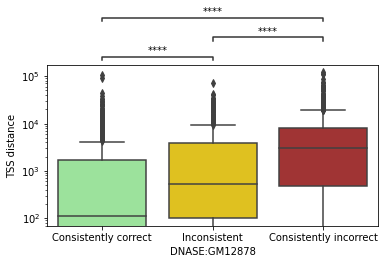

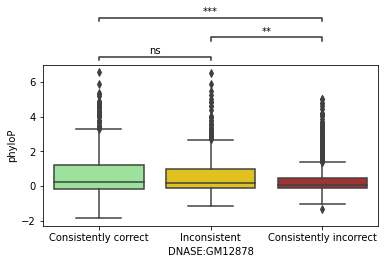

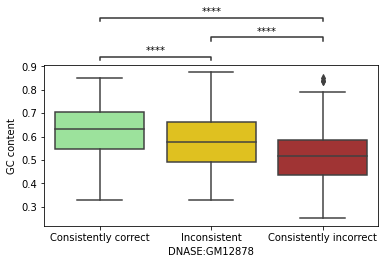

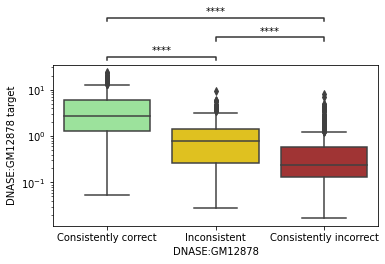

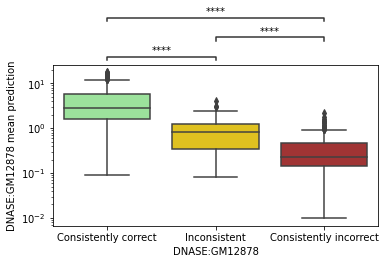

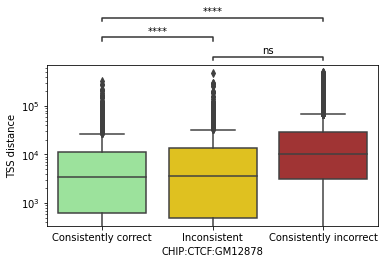

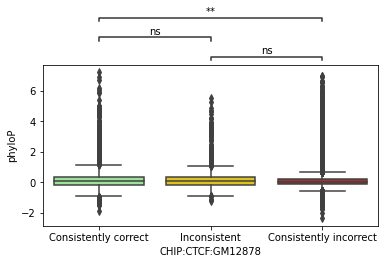

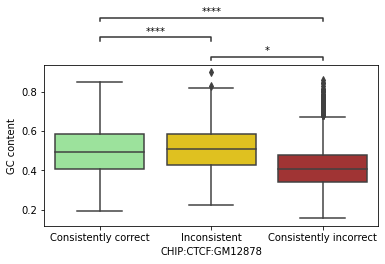

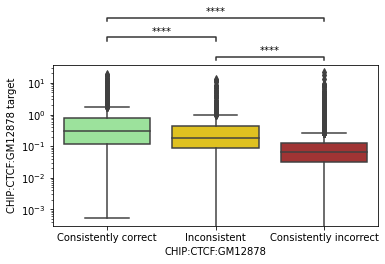

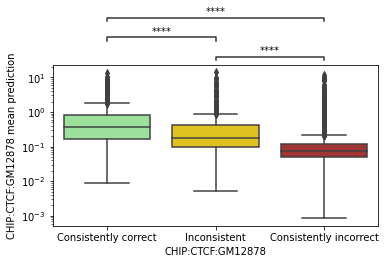

In [35]:
# look at whether different sequence attributes systematically differ for the sequences in each bin
pairs=[("Consistently correct", "Consistently incorrect"), 
       ("Consistently correct", "Inconsistent"), 
       ("Consistently incorrect", "Inconsistent")]
order=["Consistently correct", "Inconsistent", "Consistently incorrect"]
colors = ['lightgreen', 'gold', 'firebrick']

for idx in idxs:
    x=targets_with_assay_type.loc[idx, "description"]

    for y in ["TSS distance", "phyloP", "GC content", f"{x} target", f"{x} mean prediction"]:
        # boxplot
        fig, ax = plt.subplots(figsize=(5.5,4))
        ax = sns.boxplot(data=sequences, x=x,  y=y, ax=ax, order=order, palette=colors)
        
        if y in ["TSS distance", f"{x} target", f"{x} mean prediction"]:
            ax.set_yscale("log")
            
        annotator = Annotator(ax, pairs, data=sequences, x=x, y=y)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
        annotator.apply_and_annotate()

        plt.tight_layout()
        plt.savefig(f"{plot_dir}/track_{idx}_{y.replace(' ', '_')}_boxplot.pdf", dpi=300)